## Summary
* In this tutorial, we will use apply a differentially private (DP) logistic regression model using the Tensorflow Privayc libray on the heart disease dataset.
* We will calculate the privacy guarantees provided by the DP model.
* We will complete a grid search to find hyperparameters that offer good privacy while maintaining an accceptable level of utility.

## Installs

References 



*   EDA: https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
*   TFP Code: https://github.com/tensorflow/privacy/tree/master/


In [1]:
pip install tensorflow_privacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import math

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow.compat.v1 as tf

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers import dp_optimizer


## EDA and Preprocessing


The heart disese prediction dataset can be downloaded from [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci).

In [5]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Data contains: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Percentage of Patients With No Heart Disease: 45.54%
Percentage of Patients With Heart Disease: 54.46%


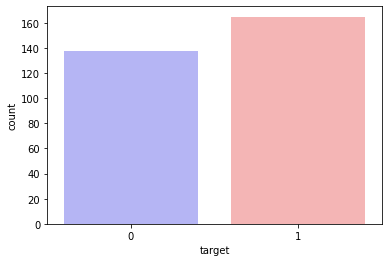

In [6]:
#Target
df.target.value_counts()
countNoDisease = len(df[df.target == 0])
countHaveDisease = len(df[df.target == 1])
print("Percentage of Patients With No Heart Disease: {:.2f}%".format((countNoDisease / (len(df.target))*100)))
print("Percentage of Patients With Heart Disease: {:.2f}%".format((countHaveDisease / (len(df.target))*100)))
sns.countplot(x="target", data=df, palette="bwr")
plt.show()

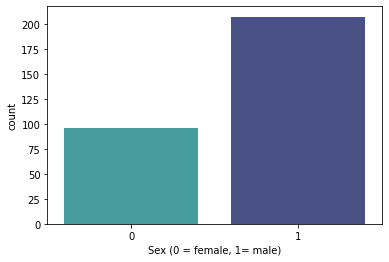

Percentage of Female Patients: 31.68%
Percentage of Male Patients: 68.32%


In [7]:
sns.countplot(x='sex', data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()
countFemale = len(df[df.sex == 0])
countMale = len(df[df.sex == 1])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.sex))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.sex))*100)))

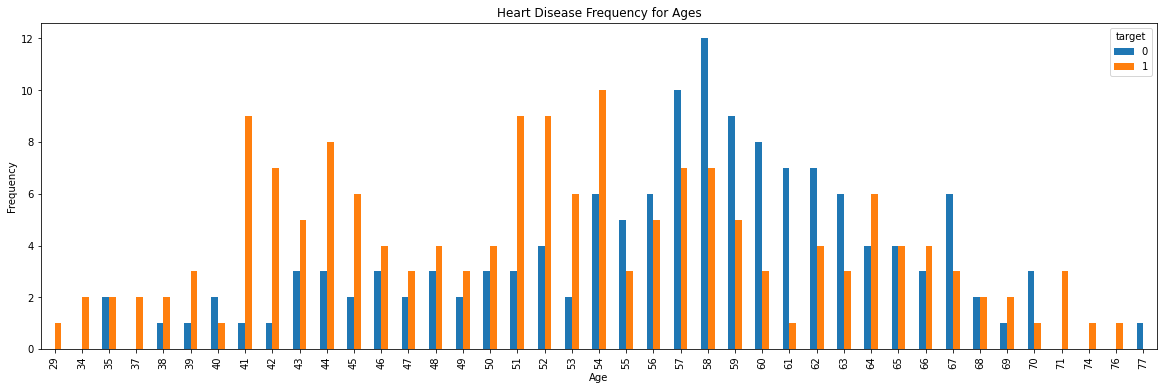

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
#plt.savefig('heartDiseaseAndAges.png')
plt.show()

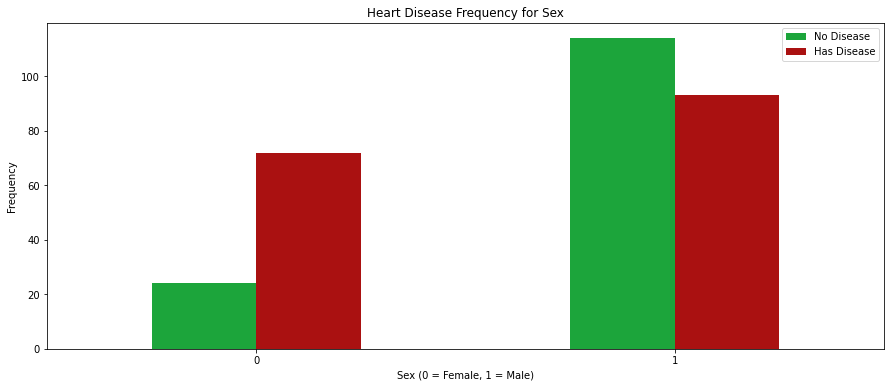

In [9]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["No Disease", "Has Disease"])
plt.ylabel('Frequency')
plt.show()

In [10]:
#one hot encode the categorical features
a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")

In [11]:
frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,...,0,0,1,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,...,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,...,1,0,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,...,0,0,0,0,0,1,0,0,0,1


In [12]:
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [13]:
print('Data Sum of Null Values \n')
df.isnull().sum()

Data Sum of Null Values 



age         0
sex         0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
ca          0
target      0
cp_0        0
cp_1        0
cp_2        0
cp_3        0
thal_0      0
thal_1      0
thal_2      0
thal_3      0
slope_0     0
slope_1     0
slope_2     0
dtype: int64

In [14]:
y = df.target.values
x_data = df.drop(['target'], axis = 1)

In [15]:
# min-max normalization
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [17]:
y_train

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

In [18]:
x_train.shape

(242, 21)

In [19]:
training_size = x_train.shape[0]
training_size

242

## Logistic Regression Model

In [20]:
def lr_model_fn(features, labels, mode, nclasses, dim, regularizer, dpsgd, data_l2_norm, noise_multiplier, learning_rate):
  """Model function for logistic regression."""
  input_layer = tf.reshape(features['x'], tuple([-1]) + dim)
  logits = tf.keras.layers.Dense(
      units=nclasses,
      kernel_regularizer=tf.keras.regularizers.L2(l2=regularizer),
      bias_regularizer=tf.keras.regularizers.L2(l2=regularizer)).apply(
          input_layer)

  # Calculate loss as a vector (to support microbatches in DP-SGD).
  vector_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits) + tf.losses.get_regularization_loss()

  # Define mean of loss across minibatch (for reporting through tf.Estimator).
  scalar_loss = tf.reduce_mean(vector_loss)

  # Configure the training op (for TRAIN mode).
  if mode == tf.estimator.ModeKeys.TRAIN:
      
    if dpsgd:
      # The loss function is L-Lipschitz with L = sqrt(2*(||x||^2 + 1)) where
      # ||x|| is the norm of the data.
      # We don't use microbatches (thus speeding up computation), since no
      # clipping is necessary due to data normalization.
      optimizer = dp_optimizer.DPGradientDescentGaussianOptimizer(
          l2_norm_clip=math.sqrt(2 * (data_l2_norm**2 + 1)),
          noise_multiplier=noise_multiplier,
          num_microbatches=1,
          learning_rate=learning_rate)
      opt_loss = vector_loss
    else:
      optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
      opt_loss = scalar_loss
    global_step = tf.train.get_global_step()
    train_op = optimizer.minimize(loss=opt_loss, global_step=global_step)
   
    # In the following, we pass the mean of the loss (scalar_loss) rather than
    # the vector_loss because tf.estimator requires a scalar loss. This is only
    # used for evaluation and debugging by tf.estimator. The actual loss being
    # minimized is opt_loss defined above and passed to optimizer.minimize().
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=scalar_loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode).
  elif mode == tf.estimator.ModeKeys.EVAL:
    eval_metric_ops = {
        'accuracy':
            tf.metrics.accuracy(
                labels=labels, predictions=tf.argmax(input=logits, axis=1))
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=scalar_loss, eval_metric_ops=eval_metric_ops)

In [21]:
def normalize_data(data, data_l2_norm):
  """Normalizes data such that each samples has bounded L2 norm.

  Args:
    data: the dataset. Each row represents one samples.
    data_l2_norm: the target upper bound on the L2 norm.
  """
  for i in range(data.shape[0]):
    norm = np.linalg.norm(data[i])
    if norm > data_l2_norm:
      data[i] = data[i] / norm * data_l2_norm

  return data

In [22]:
def print_privacy_guarantees(epochs, batch_size, samples, noise_multiplier):
  """Tabulating position-dependent privacy guarantees."""
  if noise_multiplier == 0:
    print('No differential privacy (additive noise is 0).')
    return

  print('In the conditions of Theorem 34 (https://arxiv.org/abs/1808.06651) '
        'the training procedure results in the following privacy guarantees.')

  print('Out of the total of {} samples:'.format(samples))

  steps_per_epoch = samples // batch_size
  orders = np.concatenate(
      [np.linspace(2, 20, num=181),
       np.linspace(20, 100, num=81)])
  delta = 1 / (samples*1.1)
  for p in (.5, .9, .99, 1.0):
    steps = math.ceil(steps_per_epoch * p)  # Steps in the last epoch.
    coef = 2 * (noise_multiplier * batch_size)**-2 * (
        # Accounting for privacy loss
        (epochs - 1) / steps_per_epoch +  # ... from all-but-last epochs
        1 / (steps_per_epoch - steps + 1))  # ... due to the last epoch
    # Using RDP accountant to compute eps. Doing computation analytically is
    # an option.
    rdp = [order * coef for order in orders]
    eps, _, _ = get_privacy_spent(orders, rdp, target_delta=delta)
    print('\t{:g}% enjoy at least ({:.2f}, {})-DP'.format(
        p * 100, eps, delta))

  # Compute privacy guarantees for the Sampled Gaussian Mechanism.
  rdp_sgm = compute_rdp(batch_size / samples, noise_multiplier,
                        epochs * steps_per_epoch, orders)
  eps_sgm, _, _ = get_privacy_spent(orders, rdp_sgm, target_delta=delta)
  print('By comparison, DP-SGD analysis for training done with the same '
        'parameters and random shuffling in each epoch guarantees '
        '({:.2f}, {})-DP for all samples.'.format(eps_sgm, delta))
  
  return eps, delta


In [23]:
def train(noise_multiplier, 
            batch_size,
            regularizer = 0,
            data_l2_norm = 8,
            dpsgd=True, learning_rate=0.01, epochs=120,  model_dir=None,
            print_outputs = False):

    if data_l2_norm <= 0:
        raise ValueError('data_l2_norm must be positive.')
    if dpsgd and learning_rate > 8 / data_l2_norm**2:
        raise ValueError('The amplification-by-iteration analysis requires'
                        'learning_rate <= 2 / beta, where beta is the smoothness'
                        'of the loss function and is upper bounded by ||x||^2 / 4'
                        'with ||x|| being the largest L2 norm of the samples.')

    # Load training and test data.
    # Smoothness = ||x||^2 / 4 where ||x|| is the largest L2 norm of the samples.
    # To get bounded smoothness, we normalize the data such that each sample has a bounded L2 norm.
    train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size = 0.2, random_state=0)
    
    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()
    train_data = normalize_data(train_data, data_l2_norm=data_l2_norm)
    test_data = normalize_data(test_data, data_l2_norm=data_l2_norm)

    # Instantiate tf.Estimator.
    # pylint: disable=g-long-lambda
    model_fn = lambda features, labels, mode: lr_model_fn(
        features, labels, mode, nclasses=2, dim=train_data.shape[1:], 
        regularizer=regularizer, dpsgd=dpsgd, data_l2_norm=data_l2_norm, 
        noise_multiplier=noise_multiplier, learning_rate=learning_rate)
    mnist_classifier = tf.estimator.Estimator(
        model_fn=model_fn, model_dir=model_dir)

    # Create tf.Estimator input functions for the training and test data.
    # To analyze the per-user privacy loss, we keep the same orders of samples in
    # each epoch by setting shuffle=False.
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': train_data},
        y=train_labels,
        batch_size=batch_size,
        num_epochs=epochs,
        shuffle=False)
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': test_data}, y=test_labels, num_epochs=1, shuffle=False)

    # Train the model.
    num_samples = train_data.shape[0]
    steps_per_epoch = num_samples // batch_size

    mnist_classifier.train(
        input_fn=train_input_fn, steps=steps_per_epoch * epochs)

    # Evaluate the model and print results.
    train_results = mnist_classifier.evaluate(input_fn=train_input_fn)
    print('Train accuracy after {} epochs is: {:.2f}'.format(
        epochs, train_results['accuracy']))
    valid_results = mnist_classifier.evaluate(input_fn=valid_input_fn)
    print('Test accuracy after {} epochs is: {:.2f}'.format(
        epochs, valid_results['accuracy']))
    if dpsgd:
        eps_99, delta = print_privacy_guarantees(
            epochs=epochs,
            batch_size=batch_size,
            samples=num_samples,
            noise_multiplier=noise_multiplier,
        )
    
    return eps_99, delta, train_results['accuracy'], valid_results['accuracy']

In [24]:
def train_grid_search(noise_multipliers, 
                    batch_sizes,
                    data_l2_norms,
                    regularizer = 0,
                    dpsgd=True, learning_rate=0.01, epochs=120,  model_dir=None,
                    print_outputs = False):
    
    table_outputs = []
    for batch_size in batch_sizes:
        for data_l2_norm in data_l2_norms:
            for noise_multiplier in noise_multipliers:
                eps, delta, train_accuracy, valid_accuracy = train(noise_multiplier, 
                    batch_size,
                    regularizer = regularizer,
                    data_l2_norm = data_l2_norm,
                    dpsgd=dpsgd, learning_rate=learning_rate, epochs=epochs,  model_dir=model_dir,
                    print_outputs = print_outputs)
                
                table_outputs.append([noise_multiplier,  batch_size, regularizer, data_l2_norm, learning_rate, epochs,
                                        train_accuracy, valid_accuracy, eps, delta])
                 
    df = pd.DataFrame(table_outputs, columns=['noise multiplier', 'Batch size', 'Regularizer', 'Data L2 Norm',
                                               'learning rate', 'Epochs', 
                                                'Training accuracy','Validation accuracy', 
                                                'Epsilon', 'Delta'])

    return df

In [25]:
GradientDescentOptimizer = tf.train.GradientDescentOptimizer

noise_multipliers = [1, 2, 3, 5]
data_l2_norms = [0.8, 1.0, 1.2]
batch_sizes = [11, 22, 242]

df = train_grid_search(noise_multipliers=noise_multipliers, 
                    batch_sizes = batch_sizes,
                    regularizer = 0,
                    data_l2_norms = data_l2_norms,
                    dpsgd=True, learning_rate=0.01, epochs=120,  model_dir=None,
                    print_outputs = False)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/fk/yggmcgc53hg46v7tyt18v44r0000gn/T/tmpqr8975uc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use Vari

/Users/ethan/anaconda3/envs/pets/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-09-01 15:53:31.689845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/fk/yggmcgc53hg46v7tyt18v44r0000gn/T/tmpqr8975uc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.74299043, step = 0
INFO:tensorflow:global_step/sec: 780.69
INFO:tensorflow:loss = 0.5862505, step = 100 (0.128 sec)
INFO:tensorflow:global_step/sec: 1427.2
INFO:tensorflow:loss = 0.7119626, step = 200 (0.070 sec)
INFO:tensorflow:global_step/sec: 1402.74
INFO:tensorflow:loss = 0.6412052, step = 300 (0.071 sec)
INFO:tensorflow:global_step/sec: 1437.13
INFO:tensorflow:loss = 0.69405687, step = 400 (0.070 sec)
INFO:tensorflow:global_step/sec: 1453.03
INFO:tensorflow:loss = 0.5333739, step = 500 (0.069 sec)
INFO:tensorflow:global_step/sec: 1458.93
INFO:tensorflow:loss = 0.71553516, step = 600 (0.069 sec)
INFO:tensorflow:g

KeyboardInterrupt: 

In [26]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


Note in the table below, the Epsilon value is the epsilon enjoyed by 100% of the input value.

In [27]:
df.sort_values(by=['Validation accuracy', 'Epsilon'], ascending=[False, True])

KeyError: 'Validation accuracy'